Load file names and targets

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# load image filenames with corresponding targets
def load_dataset(path):
    data = load_files(path)
    imgs = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 7)
    return imgs, targets

train_filenames, train_targets = load_dataset("../data/processed/train")
test_filenames, test_targets = load_dataset("../data/processed/test")

print("There are %d training images" % len(train_filenames))
print("There are %d test images" % len(test_filenames))

There are 28709 training images
There are 7178 test images


helpers to load image file

In [2]:
from keras.preprocessing import image
from tqdm import tqdm
def my_load_image(img_path):
    img = image.load_img(img_path, target_size=(48,48))
    arr = image.img_to_array(img)
    return np.expand_dims(arr, axis=0)

def my_load_images(paths):
    imgs = [my_load_image(p) for p in tqdm(paths)]
    return np.vstack(imgs)

test helpers

In [3]:
l = my_load_image(train_filenames[0] )
print(l.shape)

(1, 48, 48, 3)


Create model

In [12]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

proto = Sequential()

proto.add(Conv2D(filters=32,kernel_size=2,padding='same',activation='relu',input_shape=(48,48,3)))
proto.add(MaxPooling2D(pool_size=2))
proto.add(Conv2D(filters=64,kernel_size=2,padding='same',activation='relu'))
proto.add(MaxPooling2D(pool_size=2))
proto.add(Conv2D(filters=128,kernel_size=2,padding='same',activation='relu'))
proto.add(MaxPooling2D(pool_size=2))
proto.add(Flatten())
proto.add(Dense(256,activation='relu'))
proto.add(Dense(512,activation='tanh'))
proto.add(Dense(7,activation='softmax'))

proto.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 32)        416       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 64)        8256      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 128)       32896     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)             

In [ ]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

proto = Sequential()

proto.add(Conv2D(filters=32,kernel_size=2,padding='same',activation='relu',input_shape=(48,48,3)))
proto.add(MaxPooling2D(pool_size=2))
proto.add(Conv2D(filters=64,kernel_size=2,padding='same',activation='relu'))
proto.add(MaxPooling2D(pool_size=2))
proto.add(Conv2D(filters=128,kernel_size=2,padding='same',activation='relu'))
proto.add(MaxPooling2D(pool_size=2))
proto.add(Flatten())
proto.add(Dense(256,activation='relu'))
proto.add(Dense(512,activation='tanh'))
proto.add(Dense(7,activation='softmax'))

proto.summary()

Compile

In [13]:
proto.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

load train image inputs

In [5]:
train_inputs = my_load_images(train_filenames)
train_inputs /= 255
test_inputs = my_load_images(test_filenames)
test_inputs /= 255

100%|████████████████████████████████████████████████████████████████████████████| 7178/7178 [00:02<00:00, 3246.37it/s]


<h2>save the np arrays (not used) (do not run)</h2>


In [40]:
np.save("train_inputs", train_inputs)
np.save("train_targets", train_targets)
np.save("test_inputs", test_inputs)
np.save("test_targets", test_targets)

train model

In [14]:
from keras.callbacks import ModelCheckpoint

epoch = 10

checkpointer = ModelCheckpoint(filepath='..\models\mycnn_prototype.hdf5',verbose=1,save_best_only= True)

hist = proto.fit(train_inputs, train_targets , 
          validation_data=(test_inputs , test_targets),
          epochs= epoch, batch_size=40, callbacks=[checkpointer], verbose=1)

Epoch 1/10
717/718 [============================>.] - ETA: 0s - loss: 1.6221 - accuracy: 0.3529
Epoch 00001: val_loss improved from inf to 1.43592, saving model to ..\models\mycnn_prototype.hdf5
718/718 [==============================] - 40s 56ms/step - loss: 1.6223 - accuracy: 0.3529 - val_loss: 1.4359 - val_accuracy: 0.4507
Epoch 2/10
717/718 [============================>.] - ETA: 0s - loss: 1.3667 - accuracy: 0.4708
Epoch 00002: val_loss improved from 1.43592 to 1.30487, saving model to ..\models\mycnn_prototype.hdf5
718/718 [==============================] - 41s 58ms/step - loss: 1.3662 - accuracy: 0.4711 - val_loss: 1.3049 - val_accuracy: 0.5015
Epoch 3/10
717/718 [============================>.] - ETA: 0s - loss: 1.2493 - accuracy: 0.5216
Epoch 00003: val_loss improved from 1.30487 to 1.24472, saving model to ..\models\mycnn_prototype.hdf5
718/718 [==============================] - 40s 56ms/step - loss: 1.2492 - accuracy: 0.5216 - val_loss: 1.2447 - val_accuracy: 0.5251
Epoch 4/

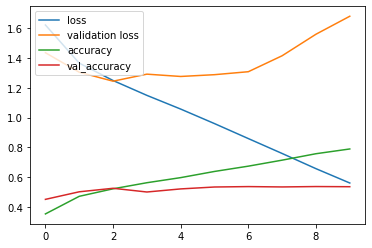

In [15]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.legend(loc="upper left")
